## Overview

This document summarizes the 2016 BY performance for the TRMG2 compared to the TRMv6.2


In [33]:
import pandas as pd
from siuba import *
import numpy as np
from plotnine import *
from shared_utils import geography_utils 

pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.display.float_format = '{:,.2f}'.format





In [34]:
hwy_2016_g2 =  pd.read_csv('TRMG2_2016.csv')
hwy_2016_v6 =  pd.read_csv('TRMv6_2016.csv')

count =  pd.read_csv('TRM6_Count_2016_Observed.csv')



temp = (
count 
    >>select(_.ID, _.Daily_Counts)
)

temp = pd.merge(hwy_2016_v6, temp)

hwy_2016_v6_counts = (
temp
    >>filter(_.Daily_Counts > 0)
)



C:\Users\JacobFo\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3418: DtypeWarning:

Columns (49,50,51,55,56,57,59) have mixed types.Specify dtype option on import or set low_memory=False.

C:\Users\JacobFo\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3418: DtypeWarning:

Columns (20,21,25,26) have mixed types.Specify dtype option on import or set low_memory=False.



In [35]:
hwy_2016_g2.pivot_table(values="Total_Flow_Daily", index="MPO",  aggfunc=[np.sum, np.mean],fill_value=0)

,sum,mean
,Total_Flow_Daily,Total_Flow_Daily
MPO,,
CAMPO,"87,767,380.48","13,249.91"
DCHC,"44,499,404.10","12,282.47"
None,"8,027,109.89","4,769.52"


## Total Daily Flow by MPO: All Links

In [36]:
#hide_input
hwy_2016_g2.pivot_table(values="Total_Flow_Daily", index="MPO",  aggfunc=[np.sum, np.mean],fill_value=0)

,sum,mean
,Total_Flow_Daily,Total_Flow_Daily
MPO,,
CAMPO,"87,767,380.48","13,249.91"
DCHC,"44,499,404.10","12,282.47"
None,"8,027,109.89","4,769.52"


In [37]:
#hide_input
import numpy as np

hwy_2016_g2.pivot_table(values="Total_Flow_Daily", index="MPO",  aggfunc=[np.sum, np.mean],fill_value=0).head()

,sum,mean
,Total_Flow_Daily,Total_Flow_Daily
MPO,,
CAMPO,"87,767,380.48","13,249.91"
DCHC,"44,499,404.10","12,282.47"
None,"8,027,109.89","4,769.52"


## Total Daily Flow by MPO: Links w/ Counts

In [38]:
#hide_input
group_cols = ["MPO"]
sum_cols = ["Total_Flow_Daily"]

hwy_2016_g2_counts = hwy_2016_g2[hwy_2016_g2.DailyCount > 0]


by_mpo_g2 = geography_utils.aggregate_by_geography(
    hwy_2016_g2_counts,
    group_cols=group_cols,
    sum_cols = sum_cols,
)

by_mpo_g2 =   by_mpo_g2.rename(columns={'Total_Flow_Daily': 'TRMG2'})



sum_cols = ["ToTDlyVol"]

by_mpo_v6 = geography_utils.aggregate_by_geography(
    hwy_2016_v6_counts,
    group_cols=group_cols,
    sum_cols = sum_cols,

)

by_mpo_v6["MPO"].replace({1: "CAMPO", 2: "DCHC", 0: "None"}, inplace=True)
by_mpo_v6 = by_mpo_v6.rename(columns={'ToTDlyVol': 'TRMv6.2'}) 
by_mpo = pd.merge(by_mpo_g2, by_mpo_v6)
by_mpo['Flow Difference']=by_mpo['TRMG2']-by_mpo['TRMv6.2']
by_mpo['PCt Difference']=(by_mpo['TRMG2']-by_mpo['TRMv6.2'])/by_mpo['TRMG2']*100
by_mpo


,MPO,TRMG2,TRMv6.2,Flow Difference,PCt Difference
0,CAMPO,"20,295,904.98","31,804,487.90","-11,508,582.93",-56.70
1,DCHC,"10,984,663.13","15,768,182.10","-4,783,518.97",-43.55
2,None,"2,005,225.04","4,956,043.67","-2,950,818.64",-147.16


### County Summaries

In [39]:
#hide_input
hwy_2016_v6_counts['New_County'] = hwy_2016_v6_counts['COUNTY'].str.lower()

vmt_county_v6 = (
hwy_2016_v6_counts 
    >>group_by(County = _.New_County)
    >>summarize(Total_VMT_v6 = _.TotVMT.sum())
)

## add missing alamance to compare to TRMG2
vmt_county_v6.loc[len(vmt_county_v6.index)] = ['alamance', 0] 

vmt_county_v6 = (
vmt_county_v6
    >>arrange(_.County)
)




hwy_2016_g2['New_County'] = hwy_2016_g2['County'].str.lower()

vmt_county_g2 = (
hwy_2016_g2 
    >>group_by(County = _.New_County)
    >>summarize(Total_VMT_G2 =_.Total_VMT_Daily.sum()              
))

vmt_county_g2.loc[len(vmt_county_g2.index)] = ['external', 0] 

vmt_county_g2 = (
vmt_county_g2
    >>arrange(_.County)
)

county_comparison = pd.merge(vmt_county_v6, vmt_county_g2, on="County")
county_comparison['Difference'] = county_comparison['Total_VMT_G2']-county_comparison['Total_VMT_v6']
county_comparison['PctDifference'] = ((county_comparison['Total_VMT_G2']-county_comparison['Total_VMT_v6'])/county_comparison['Total_VMT_G2'])*100
county_comparison

,County,Total_VMT_v6,Total_VMT_G2,Difference,PctDifference
0,alamance,0.00,"4,296.48","4,296.48",100.00
1,chatham,"936,126.51","763,372.72","-172,753.79",-22.63
2,durham,"4,154,607.14","5,986,406.85","1,831,799.71",30.60
3,external,"19,617.21",0.00,"-19,617.21",-inf
4,franklin,"677,057.76","539,708.83","-137,348.93",-25.45
5,granville,"710,965.80","653,340.75","-57,625.05",-8.82
6,harnett,"520,413.73","335,142.70","-185,271.04",-55.28
7,johnston,"3,152,058.54","2,750,084.70","-401,973.84",-14.62
8,nash,"187,818.74","115,781.09","-72,037.65",-62.22
9,orange,"2,758,703.74","2,901,719.64","143,015.90",4.93


In [40]:
import ipywidgets as widgets
from ipywidgets import interact
from plotly import tools
import plotly
import plotly.express as px
from siuba import *
import pandas as pd
from plotnine import *
from siuba import arrange

w = widgets.Dropdown(options=['Total_VMT_v6','Total_VMT_G2','Difference', 'PctDifference'], value='Difference')
#w = widgets.Dropdown(options=county_comparison.columns.values, description='column',value='Difference')

@interact(Variable= w)


def f(Variable):

    
    county_comparison['temp']=county_comparison[Variable]
    temp_df = county_comparison.sort_values('temp', ascending=False)

    p = (
        temp_df
        >>group_by(_.County)
        >>arrange(_.temp)
        >>ggplot(aes("County", 'temp'))
        +geom_bar(stat='identity') 
        + labs(y=" ") 
        +theme(axis_text_x=element_text(rotation=45, hjust=1))
        

    )

        
    return p






interactive(children=(Dropdown(description='Variable', index=2, options=('Total_VMT_v6', 'Total_VMT_G2', 'Diff…

In [41]:
##COPY
import plotly
import plotly.express as px

dat = county_comparison.sort_values('Difference', ascending=False)

fig = px.bar(dat,              # our dataframe
       x="County",         # x will be the 'key' column of the dataframe
       y="Difference",
       title="Difference TRMG2 - TRMv6.2")

fig.show()

## Highway Assignment Checks TRMG2

Goal: Replicate the current TRMv6.2 summary tool and evaluation report's key metrics, while developing tool to replicate in TRMG2 format. 



 

# Vehicle Miles Traveled 

### Total VMT: TRMv6.2


In [42]:
#hide_input
vmt_v6_total = replace_nas['TotVMT'].sum()
vmt_v6_total

NameError: name 'replace_nas' is not defined

### Total VMT: TRMG2

In [ ]:
#hide_input
vmt_g2_total=hwy_2016_g2['Total_VMT_Daily'].sum()
vmt_g2_total

59765994.53828005

Percent Difference: (G2 - v6.2)/ G2

In [ ]:
#hide_input
((vmt_g2_total-vmt_v6_total)/vmt_g2_total)*100

4.749248543178484

### Total VMT by MPO: TRMv6.2

In [ ]:
#hide_input
vmt_mpo_v6 = (
replace_nas 
    >>group_by(MPO = _.MPO)
    >>summarize(Total_VMT_v6 = _.TotVMT.sum())
)


vmt_mpo_v6 = (
vmt_mpo_v6
    >>arrange(_.MPO)
)


vmt_mpo_v6

,MPO,Total_VMT_v6
0,0,"7,864,112.07"
1,1,"34,546,729.40"
2,2,"14,516,717.45"


### Total VMT by MPO: TRMG2

- missing from TRMG2 line and TAZ layer, will need to circle around to tag

In [ ]:
#hide_input
group_cols = ["MPO"]
sum_cols = ["Total_VMT_Daily"]
mean_cols = ["Total_VMT_Daily"]



by_mpo = geography_utils.aggregate_by_geography(
    hwy_2016_g2,
    group_cols=group_cols,
    sum_cols = sum_cols,
    mean_cols=mean_cols,


)

by_mpo =   by_mpo.rename(columns={'Total_VMT_Daily_x': 'Sum VMT Flow'})
by_mpo = by_mpo.rename(columns={'Total_VMT_Daily_y': 'Mean VMT'})
by_mpo

,MPO,Sum VMT Flow,Mean VMT
0,CAMPO,"36,385,516.35",476.39
1,None,"8,466,352.76",370.15
2,DCHC,"14,649,339.95",520.88
3,None,NaN,NaN


### Total VMT by County

In [ ]:

#hide_input
replace_nas['New_County'] = replace_nas['COUNTY'].str.lower()

vmt_county_v6 = (
replace_nas 
    >>group_by(County = _.New_County)
    >>summarize(Total_VMT_v6 = _.TotVMT.sum())
)

## add missing alamance to compare to TRMG2
vmt_county_v6.loc[len(vmt_county_v6.index)] = ['alamance', 0] 

vmt_county_v6 = (
vmt_county_v6
    >>arrange(_.County)
)




hwy_2016_g2['New_County'] = hwy_2016_g2['County'].str.lower()

vmt_county_g2 = (
hwy_2016_g2 
    >>group_by(County = _.New_County)
    >>summarize(Total_VMT_G2 =_.Total_VMT_Daily.sum()              
))

vmt_county_g2.loc[len(vmt_county_g2.index)] = ['external', 0] 

vmt_county_g2 = (
vmt_county_g2
    >>arrange(_.County)
)

county_comparison = pd.merge(vmt_county_v6, vmt_county_g2, on="County")
county_comparison['Difference'] = county_comparison['Total_VMT_G2']-county_comparison['Total_VMT_v6']
county_comparison['PctDifference'] = ((county_comparison['Total_VMT_G2']-county_comparison['Total_VMT_v6'])/county_comparison['Total_VMT_G2'])*100
county_comparison

,County,Total_VMT_v6,Total_VMT_G2,Difference,PctDifference
0,alamance,0.00,"993,303.30","993,303.30",100.00
1,chatham,"1,887,084.19","1,908,876.63","21,792.44",1.14
2,durham,"9,579,639.35","9,896,837.57","317,198.22",3.21
3,external,"145,265.00",0.00,"-145,265.00",-inf
4,franklin,"1,482,186.22","1,562,436.32","80,250.10",5.14
5,granville,"1,311,675.05","1,176,954.35","-134,720.71",-11.45
6,harnett,"1,099,687.87","1,001,411.44","-98,276.43",-9.81
7,johnston,"6,071,384.15","5,819,436.97","-251,947.18",-4.33
8,nash,"250,834.74","199,839.95","-50,994.79",-25.52
9,orange,"5,220,110.19","5,146,945.83","-73,164.36",-1.42


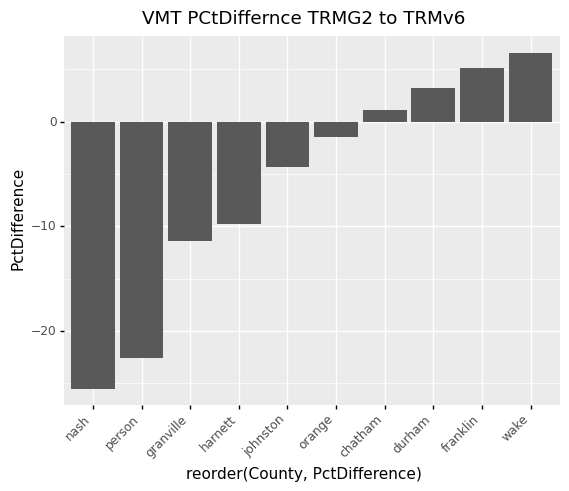

<ggplot: (135015204834)>

In [ ]:

#hide_input

(
county_comparison
    >>arrange(-_.PctDifference)
    >>filter(_.County !="alamance")
    >>filter(_.County !="external")
    >>ggplot(aes('reorder(County, PctDifference)', "PctDifference"))+geom_col()+ theme(axis_text_x = element_text(angle = 45 , hjust=1)) +ggtitle("VMT PCtDiffernce TRMG2 to TRMv6")

)


# Vehicle Hours Traveled

### Total VHT: TRMv6.2

In [ ]:
#hide_input
vht_v6_total = replace_nas['TotVHT'].sum()
vht_v6_total

1415882.0878761539

### Total VHT: TRMG2

In [ ]:
#hide_input
vht_g2_total = hwy_2016_g2['Total_VHT_Daily'].sum()
vht_g2_total

1287044.2371000464

### Total VHT by County

In [ ]:
#hide_input
vht_county_v6 = (
replace_nas 
    >>group_by(County = _.New_County)
    >>summarize(Total_VHT_v6 = _.TotVHT.sum())
)

## add missing alamance to compare to TRMG2
vht_county_v6.loc[len(vht_county_v6.index)] = ['alamance', 0] 

vht_county_v6 = (
vht_county_v6
    >>arrange(_.County)
)


hwy_2016_g2['New_County'] = hwy_2016_g2['County'].str.lower()

vht_county_g2 = (
hwy_2016_g2 
    >>group_by(County = _.New_County)
    >>summarize(Total_VHT_G2 =_.Total_VHT_Daily.sum()              
))

vht_county_g2.loc[len(vmt_county_g2.index)] = ['external', 0] 

vht_county_g2 = (
vht_county_g2
    >>arrange(_.County)
)

county_comparison = pd.merge(vht_county_v6, vht_county_g2, on="County")
county_comparison['Difference'] = county_comparison['Total_VHT_G2']-county_comparison['Total_VHT_v6']
county_comparison['PctDifference'] = ((county_comparison['Total_VHT_G2']-county_comparison['Total_VHT_v6'])/county_comparison['Total_VHT_G2'])*100

county_comparison


,County,Total_VHT_v6,Total_VHT_G2,Difference,PctDifference
0,alamance,0.00,"25,916.82","25,916.82",100.00
1,chatham,"38,290.33","36,496.28","-1,794.05",-4.92
2,durham,"246,640.25","222,062.40","-24,577.85",-11.07
3,external,"3,321.71",0.00,"-3,321.71",-inf
4,franklin,"32,199.82","31,519.27",-680.55,-2.16
5,granville,"25,698.70","22,038.49","-3,660.21",-16.61
6,harnett,"24,472.33","21,624.69","-2,847.64",-13.17
7,johnston,"124,541.80","108,030.82","-16,510.97",-15.28
8,nash,"4,109.60","3,125.57",-984.03,-31.48
9,orange,"122,548.29","111,874.43","-10,673.87",-9.54


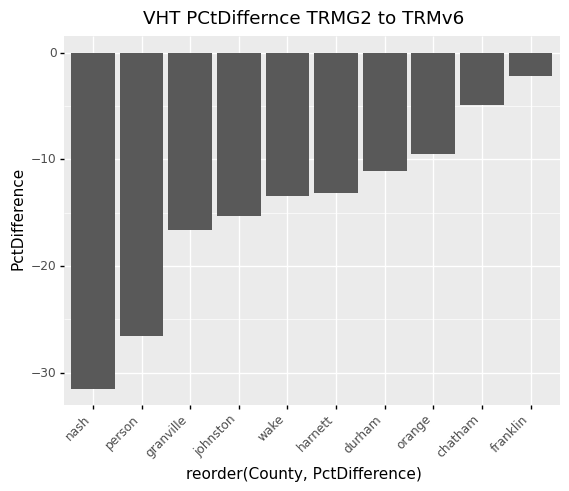

<ggplot: (135020028778)>

In [ ]:
#hide_input
(
county_comparison
    >>arrange(-_.PctDifference)
    >>filter(_.County !="alamance")
    >>filter(_.County !="external")
    >>ggplot(aes('reorder(County, PctDifference)', "PctDifference"))+geom_col()+ theme(axis_text_x = element_text(angle = 45 , hjust=1)) +ggtitle("VHT PCtDiffernce TRMG2 to TRMv6")

)


# Total Daily Volume - All Links


### Total Daily Volume: TRMv6.2

In [ ]:
#hide_input
tot_vol_v6_total = replace_nas['ToTDlyVol'].sum()
tot_vol_v6_total

186392885.39225224

### Total Daily Volume: TRMG2

In [ ]:
#hide_input
tot_vol_g2_total = hwy_2016_g2['Total_Flow_Daily'].sum()
tot_vol_g2_total

306663903.1572029

### Total Daily Volume by County

In [ ]:
#hide_input
tot_vol_county_v6 = (
replace_nas 
    >>group_by(County = _.New_County)
    >>summarize(Total_Flow_v6 = _.ToTDlyVol.sum())
)

## add missing alamance to compare to TRMG2
tot_vol_county_v6.loc[len(tot_vol_county_v6.index)] = ['alamance', 0] 

tot_vol_county_v6 = (
tot_vol_county_v6
    >>arrange(_.County)
)


hwy_2016_g2['New_County'] = hwy_2016_g2['County'].str.lower()

tot_vol_county_g2 = (
hwy_2016_g2 
    >>group_by(County = _.New_County)
    >>summarize(Total_Flow_G2 =_.Total_Flow_Daily.sum()              
))

tot_vol_county_g2.loc[len(tot_vol_county_g2.index)] = ['external', 0] 

tot_vol_county_g2 = (
tot_vol_county_g2
    >>arrange(_.County)
)

county_comparison = pd.merge(tot_vol_county_v6, tot_vol_county_g2, on="County")
county_comparison['Difference'] = county_comparison['Total_Flow_G2']-county_comparison['Total_Flow_v6']
county_comparison['PctDifference'] = ((county_comparison['Total_Flow_G2']-county_comparison['Total_Flow_v6'])/county_comparison['Total_Flow_G2'])*100

county_comparison


,County,Total_Flow_v6,Total_Flow_G2,Difference,PctDifference
0,alamance,0.00,"5,365,310.61","5,365,310.61",100.00
1,chatham,"2,498,666.22","5,943,315.38","3,444,649.16",57.96
2,durham,"43,217,816.60","60,486,993.38","17,269,176.78",28.55
3,external,"676,773.89",0.00,"-676,773.89",-inf
4,franklin,"2,665,561.59","8,323,252.44","5,657,690.85",67.97
5,granville,"1,775,753.36","3,324,355.45","1,548,602.09",46.58
6,harnett,"1,930,055.64","4,795,670.69","2,865,615.04",59.75
7,johnston,"10,281,901.43","19,573,688.23","9,291,786.80",47.47
8,nash,"249,296.36","388,466.36","139,170.00",35.83
9,orange,"15,895,967.24","22,718,823.81","6,822,856.58",30.03


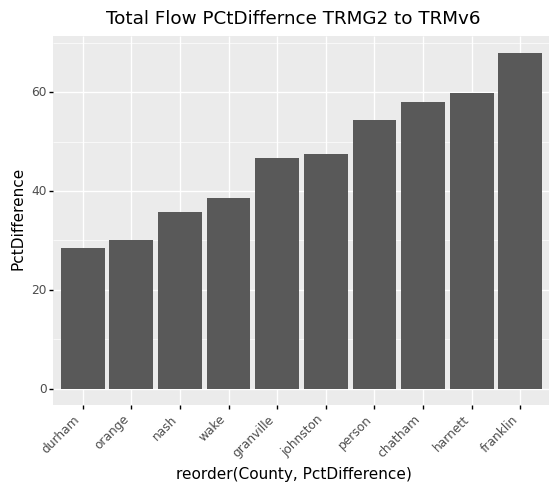

<ggplot: (135014097559)>

In [ ]:
#hide_input
(
county_comparison
    >>arrange(-_.PctDifference)
    >>filter(_.County !="alamance")
    >>filter(_.County !="external")
    >>ggplot(aes('reorder(County, PctDifference)', "PctDifference"))+geom_col()+ theme(axis_text_x = element_text(angle = 45 , hjust=1)) +ggtitle("Total Flow PCtDiffernce TRMG2 to TRMv6")

)


# Total Daily Volume - Links with Counts

### Total Daily Volume: TRMv6.2

In [ ]:

tot_vol_v6_total = hwy_2016_v6_counts['ToTDlyVol'].sum()
tot_vol_v6_total



52528713.675038055

### Total Daily Volume: TRMG2

In [ ]:
#hide_input
hwy_2016_g2_counts = (
hwy_2016_g2
    >>filter(_.DailyCount>0)
)

tot_vol_g2_total = hwy_2016_g2_counts['Total_Flow_Daily'].sum()
tot_vol_g2_total

56116720.94354267

Percent Difference

In [ ]:
#hide_input
((tot_vol_g2_total-tot_vol_v6_total)/tot_vol_g2_total)*100

6.393829162103747

In [ ]:
#hide_input
tot_vol_county_v6 = (
hwy_2016_v6_counts 
    >>group_by(County = _.New_County)
    >>summarize(Total_Flow_v6 = _.ToTDlyVol.sum(),
               Total_Counts_v6 = _.Daily_Counts.sum())
    >>mutate(PctDifference = (_.Total_Flow_v6 - _.Total_Counts_v6)/_.Total_Flow_v6*100)
)


hwy_2016_g2_counts['New_County'] = hwy_2016_g2_counts['County'].str.lower()

tot_vol_county_g2 = (
hwy_2016_g2_counts 
    >>group_by(County = _.New_County)
    >>summarize(Total_Flow_G2 =_.Total_Flow_Daily.sum(),
                Total_Counts_G2 = _.DailyCount.sum())
    >>mutate(PctDifference = (_.Total_Flow_G2 - _.Total_Counts_G2)/_.Total_Flow_G2*100)
)


tot_vol_county_g2.loc[len(tot_vol_county_g2.index)] = ['external', 0,0,0] 

tot_vol_county_g2 = (
tot_vol_county_g2
    >>arrange(_.County)
)

county_comparison = pd.merge(tot_vol_county_v6, tot_vol_county_g2, on="County")

county_comparison['Difference'] = county_comparison['Total_Flow_G2']-county_comparison['Total_Flow_v6']
county_comparison['PctDifference'] = ((county_comparison['Total_Flow_G2']-county_comparison['Total_Flow_v6'])/county_comparison['Total_Flow_G2'])*100

tot_flow_county = (
county_comparison
    >>select(_.County, _.Total_Flow_v6, _.Total_Flow_G2, _.PctDifference)
)
tot_flow_county

<ipython-input-26-cd808247b23c>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,County,Total_Flow_v6,Total_Flow_G2,PctDifference
0,chatham,"845,870.51","912,262.99",7.28
1,durham,"12,016,011.96","12,969,703.99",7.35
2,external,"104,807.18",0.00,-inf
3,franklin,"979,763.42","1,020,690.38",4.01
4,granville,"674,119.03","628,106.70",-7.33
5,harnett,"728,257.70","652,223.98",-11.66
6,johnston,"3,509,072.79","3,436,414.09",-2.11
7,nash,"124,308.54","66,200.31",-87.78
8,orange,"4,007,723.59","3,925,944.75",-2.08
9,person,"644,518.16","527,404.48",-22.21


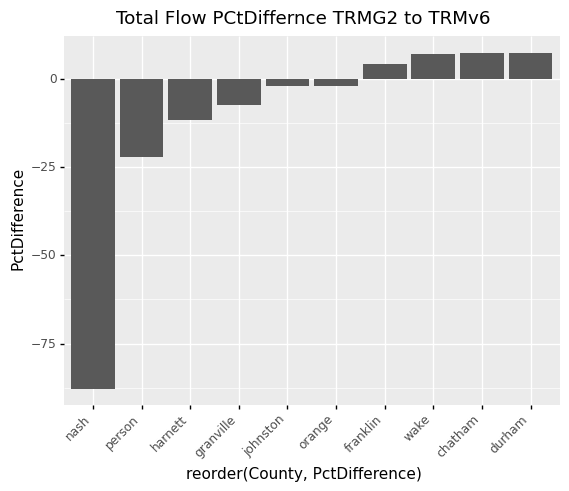

<ggplot: (134982219719)>

In [ ]:
#hide_input

(
tot_flow_county
    >>arrange(-_.PctDifference)
    >>filter(_.County !="alamance")
    >>filter(_.County !="external")
   # >>ggplot(aes("County", "PctDifference"))+geom_col()+ theme(axis_text_x = element_text(angle = 45 , hjust=1)) +ggtitle("Total Flow PCtDiffernce TRMG2 to TRMv6")
     >>ggplot(aes('reorder(County, PctDifference)', "PctDifference"))+geom_col()+ theme(axis_text_x = element_text(angle = 45 , hjust=1)) +ggtitle("Total Flow PCtDiffernce TRMG2 to TRMv6")
)


# Total Flow by Facility Type

## TRMv6.2

In [ ]:
#hide_input

hwy_2016_v6_counts['FCGroup_Tag'] = case_when(hwy_2016_v6_counts, {
    _.FCGROUP ==1 : "Freeway",
    _.FCGROUP ==2 : "Major Arterial",
    _.FCGROUP ==3: "Minor Arterial",
    _.FCGROUP ==4: "Collector",
    _.FCGROUP ==5: "Local",
    True: "CC"
})

tot_vol_fcgroup_v6 = (
hwy_2016_v6_counts 
    >>group_by(_.FCGroup_Tag)
    >>filter(_.FCGroup_Tag !="CC")
    >>summarize(Total_Flow_v6 = _.ToTDlyVol.sum(),
               Total_Counts_v6 = _.Daily_Counts.sum())
    >>mutate(PctDifference = (_.Total_Flow_v6 - _.Total_Counts_v6)/_.Total_Flow_v6*100)
)
tot_vol_fcgroup_v6

,FCGroup_Tag,Total_Flow_v6,Total_Counts_v6,PctDifference
0,Collector,"6,441,993.94",6623550,-2.82
1,Freeway,"14,257,957.00",14084500,1.22
2,Local,"4,735,795.87",4655830,1.69
3,Major Arterial,"13,835,060.62",15284820,-10.48
4,Minor Arterial,"13,151,478.38",13397660,-1.87


## TRMG2